# 1. Definição do problema

Este teste consiste em desenvolver um modelo de aprendizado de máquina capaz de classificar as amostras do conjunto de dados [dataset_cdjr.parquet.gzip](https://drive.google.com/file/d/1HXq9mczY-5OpFaXK3kk8zAgFEgEgF3jt/view?usp=sharing), fornecido para a realização do teste técnico das Lojas Americanas SA.


# 2. Dados

É um conjunto de dados pequeno de 466 entradas, composto inicialmente por 16 features (feature0, feature1, ..., feature 15) e uma coluna target, que é a classe. A coluna target é zero indicando a não ocorrência do evento que desejamos prever e um quando há ocorrência do evento que desejamos prever.

## Importação das ferramentas

In [1]:
# Bibliotecas para análise exploratória
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Necessárias para a modelagem
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import PowerTransformer, MinMaxScaler
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
import xgboost as xgb

## Análise Exploratória

In [2]:
df = pd.read_parquet('dados/dataset_cdjr.parquet.gzip')
df.head()

,feature0,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,feature9,feature10,feature11,feature12,feature13,feature14,feature15,target
337,200.0,2,662.28,39.10,-188.55,0.246978,761,0.004548,3.523703,167326,33441.06,0.019804,26.850,0.009198,94.611429,7,0
266,150.0,2,0.00,149.55,-0.45,0.150000,3,0.037975,0.000000,79,78.93,0.000000,0.000,0.000000,0.000000,0,1
236,50.0,1,346.08,30.41,-102.10,2.430952,42,0.004239,3.389618,9907,18858.77,0.018351,25.525,0.095238,86.520000,4,0
274,100.0,2,0.00,43.84,-56.16,0.150968,372,0.005854,0.000000,63544,1164.11,0.000000,0.000,0.000000,0.000000,0,1
208,50.0,1,87.56,-3.05,-94.50,0.412664,229,0.004572,0.926561,50089,1786.26,0.049019,94.500,0.004367,87.560000,1,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 466 entries, 337 to 92
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   feature0   466 non-null    float64
 1   feature1   466 non-null    int64  
 2   feature2   466 non-null    float64
 3   feature3   466 non-null    float64
 4   feature4   466 non-null    float64
 5   feature5   466 non-null    float64
 6   feature6   466 non-null    int64  
 7   feature7   466 non-null    float64
 8   feature8   466 non-null    float64
 9   feature9   466 non-null    int64  
 10  feature10  466 non-null    float64
 11  feature11  466 non-null    float64
 12  feature12  466 non-null    float64
 13  feature13  466 non-null    float64
 14  feature14  466 non-null    float64
 15  feature15  466 non-null    int64  
 16  target     466 non-null    int64  
dtypes: float64(12), int64(5)
memory usage: 65.5 KB


O dataset possui 16 colunas de features e uma de target, todas numéricas. Não há valores faltantes em nenhuma delas.

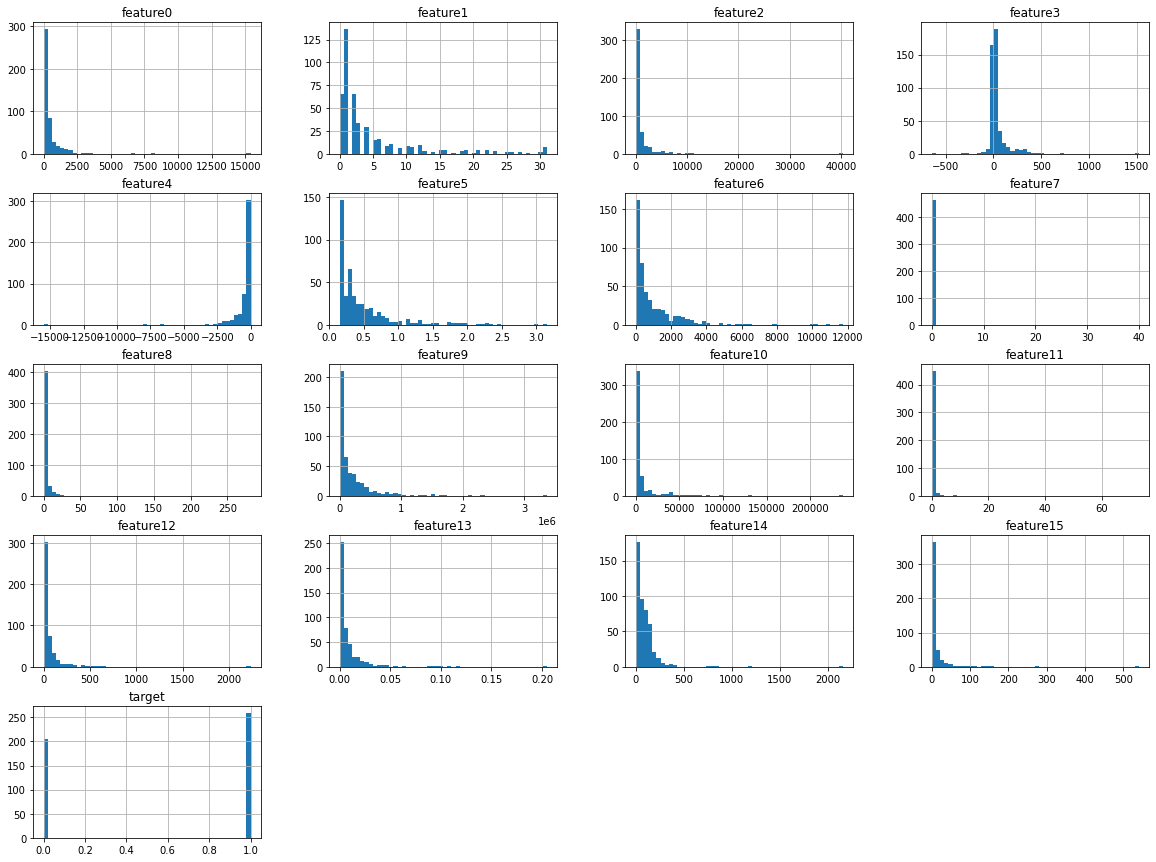

In [4]:
df.hist(bins=50, figsize=(20,15));

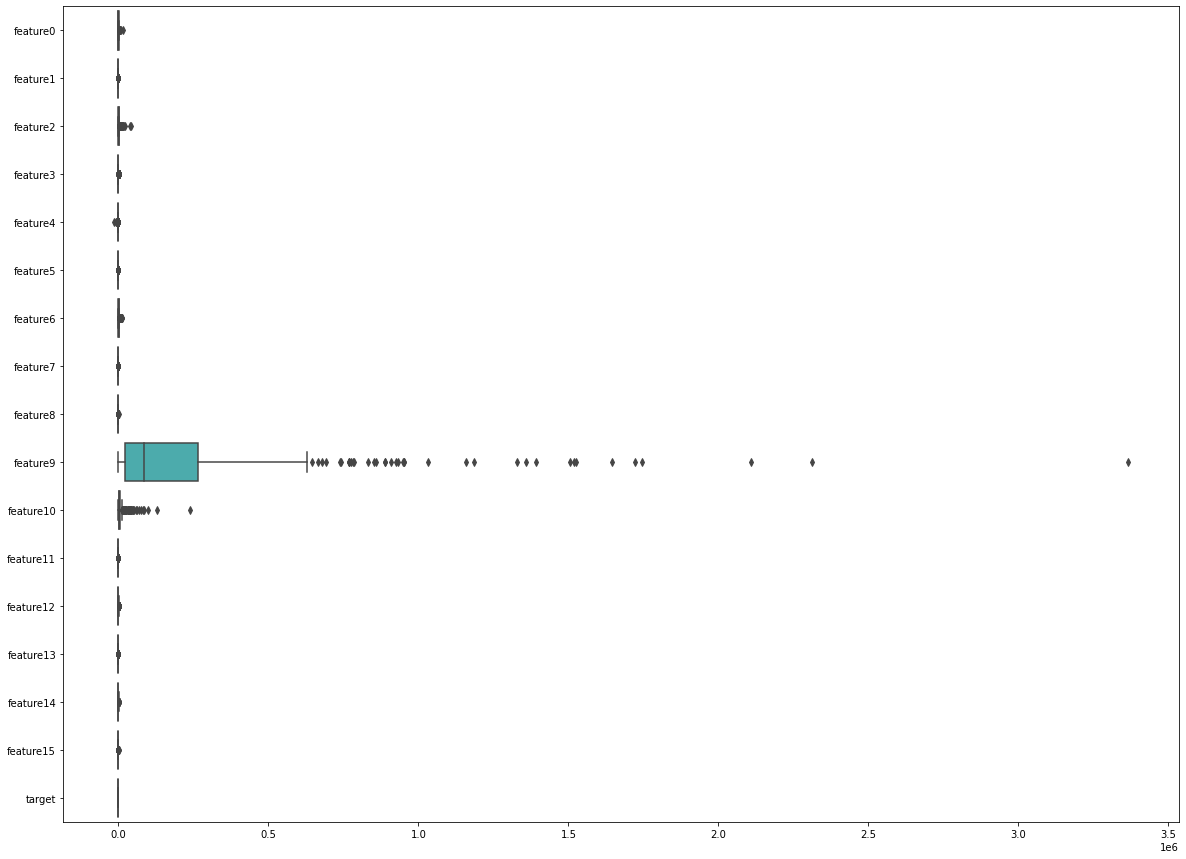

In [5]:
plt.figure(figsize=(20,15))
sns.boxplot(data=df, orient='h');

In [6]:
df.describe().round(2)

,feature0,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,feature9,feature10,feature11,feature12,feature13,feature14,feature15,target
count,466.00,466.00,466.00,466.00,466.00,466.00,466.00,466.00,466.00,466.00,466.00,466.00,466.00,466.00,466.00,466.00,466.00
mean,438.74,4.85,1244.32,44.60,-434.30,0.47,979.07,0.11,3.86,216437.82,6930.46,0.44,61.89,0.01,87.71,10.31,0.56
std,984.59,6.84,3558.70,122.09,975.56,0.45,1460.74,1.87,15.61,350862.17,17581.80,3.44,142.52,0.02,145.43,33.63,0.50
min,0.00,0.00,0.00,-645.87,-15506.35,0.15,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,50.00,1.00,0.00,-0.40,-492.04,0.17,133.50,0.00,0.00,21131.00,383.69,0.00,0.00,0.00,0.00,0.00,0.00
50%,150.00,2.00,169.83,18.36,-154.52,0.30,420.00,0.01,0.94,85328.50,1410.86,0.08,19.69,0.00,72.52,2.00,1.00
75%,500.00,6.00,1017.38,44.63,-50.18,0.57,1238.75,0.01,2.82,264503.50,5212.98,0.31,65.50,0.01,127.30,8.00,1.00
max,15400.00,31.00,40291.24,1521.90,-0.26,3.15,11731.00,40.00,281.67,3366472.00,237182.78,73.08,2232.10,0.20,2154.00,541.00,1.00


* As features possuem escalas de valores e distribuições muito divergentes, com presença de vários outliers.
* A coluna target possui somente dois valores, tratando-se de uma classificação binária.

### Proporção de valores na coluna target

In [7]:
df.target.value_counts(normalize=True).round(3)

1    0.558
0    0.442
Name: target, dtype: float64

O resultado acima mostra que pelo menos 56% dos resultados na coluna target levam o valor 1 e 44% leva o valor 0. Para não haver viés no treinamento, a divisão das classes nos sets de treinamento e teste deverão seguir a mesma proporção.

### Conclusões da análise exploratória.

* Não há dados faltantes ou errôneos no dataset, portanto não será necessário fazer imputação ou limpeza.
* As colunas possuem valores muito divergentes, com distribuições assimétricas e presença de vários outliers. Será necessário fazer uma feature scaling para o dataset estar apto a modelagem.
* Há um desequilíbrio de valores na coluna target, onde 56% dos valores são 1 e 44% dos valores são 0. Portanto, na hora de separar os sets de teste e treinamento, a distribuição das classes devem seguir esta mesma proporção.

## Preparando os dados para manipulação e modelagem

Antes de ser feita qualquer manipulação nos dados, deve-se dividir o dataset em set de teste e treinamento e usar o set de treinamento para a manipulação, para evitar ao máximo o data leakage.

As labels do set de teste e treinamento será estratificada na mesma proporção que o dataset original.

In [8]:
train_set, test_set = train_test_split(df, test_size=0.2, random_state=42, stratify=df['target'])

X_train = train_set.drop('target', axis=1)
y_train = train_set.target.copy()

X_test = test_set.drop('target', axis=1)
y_test = test_set.target.copy()

In [9]:
y_train.value_counts(normalize=True).round(3)

1    0.559
0    0.441
Name: target, dtype: float64

In [10]:
y_test.value_counts(normalize=True).round(3)

1    0.553
0    0.447
Name: target, dtype: float64

Tanto as labels de treinamento e de teste foram estratificadas de acordo com a proporção das labels encontradas no dataset completo. Deste modo, reduz-se o risco de vieses no treinamento.

### Verificando features altamente correlacionadas

Um problema que frequentemente encontramos em machine learning são as features altamente correlacionadas. Se duas features são altamente correlacionadas, então as informações que elas contêm são muito semelhantes, e é provavelmente redundante incluir ambas as features. A solução para features altamente correlacionadas é simples: remova uma delas do conjunto de dados.

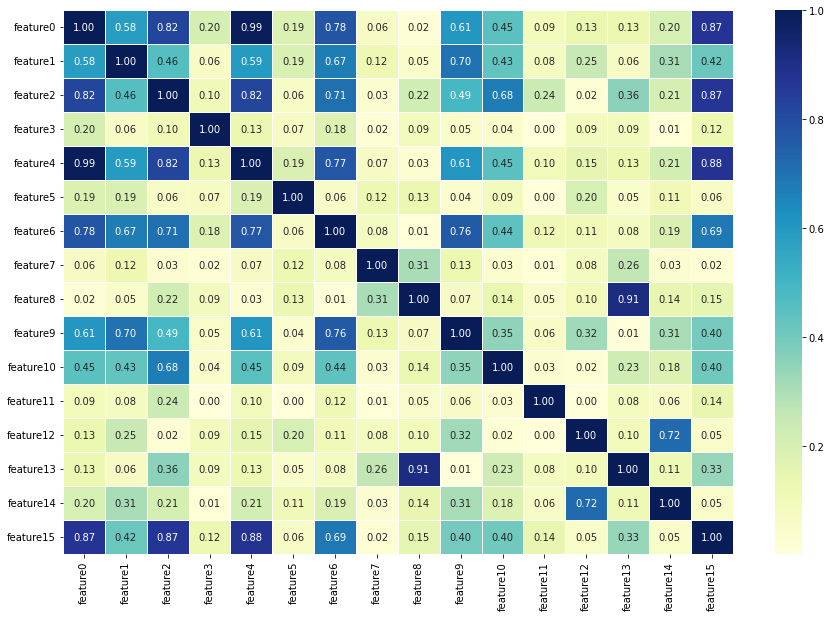

In [11]:
corr_matrix = X_train.corr().abs()

plt.figure(figsize=(15, 10))
sns.heatmap(corr_matrix, 
            annot=True, 
            linewidths=0.5, 
            fmt= ".2f", 
            cmap="YlGnBu");

Removerei qualquer feature que tenha mais de 0.95 de correlação com outra.

In [12]:
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape),k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
print(f"Coluna a ser removida: {to_drop}")

Coluna a ser removida: ['feature4']


No caso, a única feature que tem mais de 0.95 de correlação com outra é a feature 4, com 0.99 de correlação com a feature0. Manter essa feature seria redundante, portanto irei removê-la do set de treinamento e teste.

In [13]:
X_train = X_train.drop(to_drop[0], axis=1)
X_test = X_test.drop(to_drop[0], axis=1)

### Feature Scaling

Como os dados possuem muitos outliers, seria mais adequado usar um scaler mais apto a lidar com outliers, e depois aplicar o MinMax scaler para transformar os valores em números entre 0 a 1, para melhorar o treinamento do modelo. Portanto, decidi usar o scaler PowerTransformer e logo em seguida aplicar o MinMaxScaler.

In [14]:
from sklearn.pipeline import Pipeline

power_scaler = PowerTransformer()
min_max_scaler = MinMaxScaler()

pipeline = Pipeline(steps=[('p', power_scaler), ('m', min_max_scaler)])

In [15]:
# Feature scaling para o set de treinamento
X_train = pd.DataFrame(
    pipeline.fit_transform(X_train),
    columns=X_train.columns,
    index=X_train.index)

# Feature scaling para o set de teste
X_test = pd.DataFrame(
    pipeline.transform(X_test),
    columns=X_test.columns,
    index=X_test.index
)

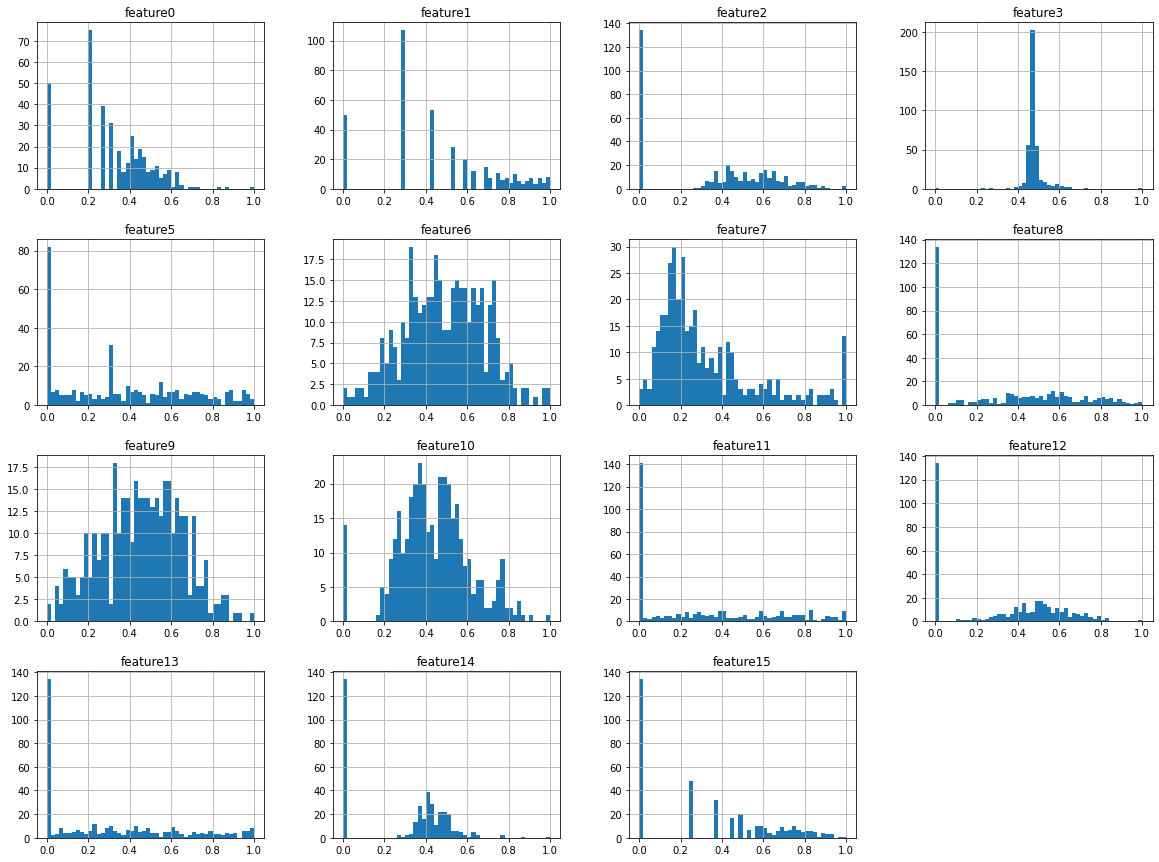

In [16]:
X_train.hist(bins=50, figsize=(20,15));

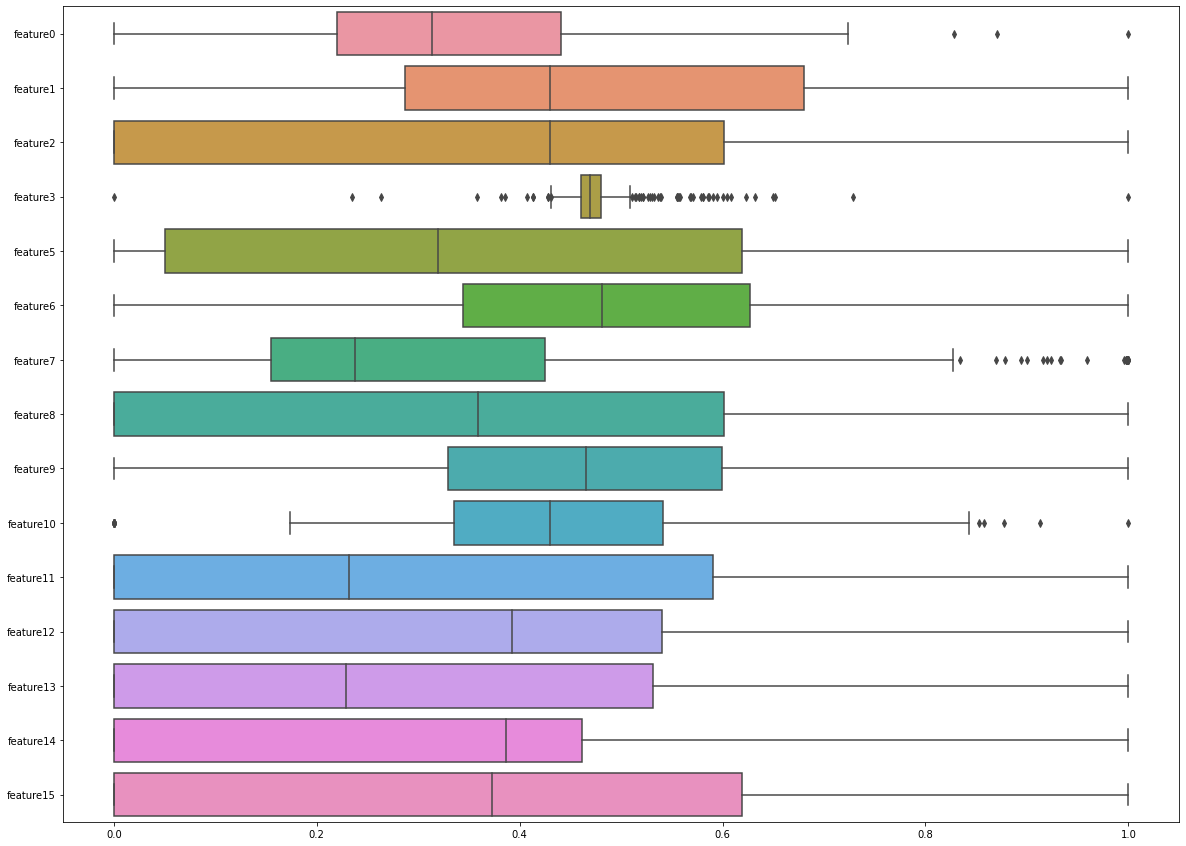

In [17]:
plt.figure(figsize=(20,15))
sns.boxplot(data=X_train, orient='h');

In [18]:
X_train.describe().round(2)

,feature0,feature1,feature2,feature3,feature5,feature6,feature7,feature8,feature9,feature10,feature11,feature12,feature13,feature14,feature15
count,372.00,372.00,372.00,372.00,372.00,372.00,372.00,372.00,372.00,372.00,372.00,372.00,372.00,372.00,372.00
mean,0.32,0.46,0.36,0.48,0.37,0.49,0.32,0.34,0.46,0.44,0.31,0.32,0.31,0.29,0.34
std,0.18,0.28,0.29,0.05,0.31,0.19,0.24,0.31,0.19,0.18,0.32,0.27,0.32,0.23,0.31
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.22,0.29,0.00,0.46,0.05,0.34,0.16,0.00,0.33,0.33,0.00,0.00,0.00,0.00,0.00
50%,0.31,0.43,0.43,0.47,0.32,0.48,0.24,0.36,0.47,0.43,0.23,0.39,0.23,0.39,0.37
75%,0.44,0.68,0.60,0.48,0.62,0.63,0.43,0.60,0.60,0.54,0.59,0.54,0.53,0.46,0.62
max,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


Todos os dados foram padronizados e posteriormente normalizados, estando adequados para a modelagem.

# 3. Modelagem

## Definição da avaliação

Como não há uma métrica de avaliação de performance do modelo definida no teste técnico, decidi usar a pontuação Area Under Curve (AUC).

A AUC é uma medida da habilidade de um classificador distinguir entre classes e é usada como um resumo da curva ROC. Quanto maior a AUC, melhor o desempenho do modelo na distinção entre as classes positivas e negativas.

Quando AUC for igual a 1, então o classificador é capaz de distinguir perfeitamente entre todos os pontos da classe positiva e negativa corretamente. Se, no entanto, a AUC for 0, então o classificador estaria prevendo todos os negativos como positivos e todos os positivos como negativos.

Antes de selecionar e validar um modelo, será feito um modelo dummy que tentará adivinhar os resultados de forma totalmente aleatória, para termos uma ideia da performance que um modelo não ideal teria.

In [19]:
class CrossValidate():
    """
    Faz uma validação cruzada e salva o valor médio de pontuação e desvio padrão.
    A classe recebe quatro argumentos:
    model: O modelo a ser usado.
    x: O dataset com as features que serão usadas.
    y: As labels do dataset.
    scoring: A métrica de avaliação que será usada."""
    def __init__(self, model, x, y, scoring):
        np.random.seed(42)
        self.scores = cross_val_score(model, x, y, cv=5, scoring=scoring)
        self.mean = self.scores.mean().round(2)
        self.std = self.scores.std().round(2)

    def display_cross_val_scores(self):
        print('Scores: ',self.scores)
        print('Mean: ',self.mean)
        print('Standard Deviation: ',self.std)
        

Pontuação do modelo dummy nos sets de validação.

In [20]:
dummy = DummyClassifier(strategy='uniform', random_state=42)

dummy_cross_val = CrossValidate(dummy, X_train, y_train, 'roc_auc')

dummy_cross_val.display_cross_val_scores()

Scores:  [0.5 0.5 0.5 0.5 0.5]
Mean:  0.5
Standard Deviation:  0.0


Pontuação do modelo dummy nos sets de teste.

In [21]:
dummy.fit(X_train, y_train)
dummy_predictions = dummy.predict(X_test)

print(classification_report(y_test, dummy_predictions))

              precision    recall  f1-score   support

           0       0.28      0.29      0.28        42
           1       0.41      0.40      0.41        52

    accuracy                           0.35        94
   macro avg       0.35      0.34      0.35        94
weighted avg       0.35      0.35      0.35        94



In [22]:
print(f"Pontuação AUC: {roc_auc_score(y_test, dummy_predictions).round(2)}")

Pontuação AUC: 0.34


Um modelo que adivinha os resultados de forma totalmente aleatória, tem uma pontuação AUC média de 0.5 nos testes de validação e pontuação AUC de apenas 0.34 no set de teste. Para um modelo ser considerado melhor que adivinhações aleatórias, terá que ter uma performance melhor que esta.

Para definir qual modelo de classificação será selecionado para a regulagem dos hiperparâmetros, testarei 5 modelos conhecidos de classificação e avaliarei os resultados preliminares deles.

In [23]:
models = {
    'KNN': KNeighborsClassifier(),
    'Logistic Regression': LogisticRegression(),
    'Random Forest Classifier': RandomForestClassifier(),
    'LinearSVC': LinearSVC(dual=False),
    'XGBoost': xgb.XGBClassifier(),
}

In [24]:
def fit_and_score(models, X_train, y_train):
    """
    Treina e avalia os modelos de machine learning.
    models : um dicionário de diferentes modelos de machine learning.
    X_train : dados de treinamento.
    y_train : labels associadas aos dados de treinamento.
    """
    # Seed para ter resultados reprodutíveis
    np.random.seed(42)

    # Listas para armazenar os resultados dos modelos
    roc_auc_means = []
    roc_auc_stds = []
    model_names = []

    # Loop nos modelos
    for name, model in models.items():
        model_cross_val = CrossValidate(model, X_train, y_train, 'roc_auc')

        # Avalia os modelos e adiciona os valores nas respectivas listas
        roc_auc_means.append(model_cross_val.mean)
        roc_auc_stds.append(model_cross_val.std)
        model_names.append(name)

    # Salva os resultados dos modelos e incluí em um dataframe
    df = pd.DataFrame(
        {
            'Mean AUC':roc_auc_means,
            'Standard Deviation':roc_auc_stds},
            index=model_names
            )
    return df

Todos os modelos selecionados irão realizar 5 testes de validação e salvarão a média das pontuações AUC e o desvio padrão e retornará os valores em um dataframe.

In [25]:
fit_and_score(models, X_train, y_train)

,Mean AUC,Standard Deviation
KNN,0.62,0.03
Logistic Regression,0.69,0.04
Random Forest Classifier,0.64,0.03
LinearSVC,0.70,0.04
XGBoost,0.63,0.04


Todos os modelos mostraram pontuações acima de 0.60 nos testes de validação, o que já é melhor do que um modelo que chuta de forma totalmente aleatória. O modelo que mostrou melhor performance entre os cinco foi o Linear SVC, com AUC média de 0.7 e desvião padrão de 0.04, portanto este será o modelo selecionado para a regulagem dos hiperparâmetros.

## Regulando hiperparâmetros

Usarei o GridSeachCV para fazer um teste exaustivo entre os diferentes hiperparâmetros do modelo Ridge Classifier e selecionarei a melhor combinação de hiperparâmetros para o modelo final.

In [26]:
linear_clf = LinearSVC(dual=False, max_iter=10000)

In [27]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'C': [0.1,1, 10, 100, 1000],
    'penalty':['l1','l2'],
    }

linear_grid = GridSearchCV(linear_clf, param_grid, cv=5, scoring='roc_auc')
linear_grid.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=LinearSVC(dual=False, max_iter=10000),
             param_grid={'C': [0.1, 1, 10, 100, 1000], 'penalty': ['l1', 'l2']},
             scoring='roc_auc')

*Obs: Algumas combinações no GridSearchCV não são compatíveis, por isso os avisos.

In [28]:
print(f"Melhores parâmetros: {linear_grid.best_params_}\n")

Melhores parâmetros: {'C': 1, 'penalty': 'l1'}



In [29]:
final_model = linear_grid.best_estimator_

# 4. Avaliação

Pontuação do modelo final nos testes de validação.

In [30]:
linear_cross_val = CrossValidate(final_model, X_train, y_train, 'roc_auc')
linear_cross_val.display_cross_val_scores()

Scores:  [0.7020202  0.67604618 0.72247024 0.76570584 0.64005913]
Mean:  0.7
Standard Deviation:  0.04


Regular os hiperparâmetros não teve um efeito significativo na mudança dos resultados. O modelo será testado com dados não vistos ainda, os dados de teste.

In [31]:
predictions = final_model.predict(X_test)

print(f"Pontuação AUC Modelo Final: {roc_auc_score(y_test, predictions).round(2)}")
print(f"Pontuação AUC Modelo Dummy: {roc_auc_score(y_test, dummy_predictions).round(2)}")


Pontuação AUC Modelo Final: 0.72
Pontuação AUC Modelo Dummy: 0.34


O modelo final mostrou uma performance aproximadamente 111% maior do que o modelo dummy nos dados de teste.

In [32]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.71      0.64      0.67        42
           1       0.73      0.79      0.76        52

    accuracy                           0.72        94
   macro avg       0.72      0.72      0.72        94
weighted avg       0.72      0.72      0.72        94



F1 médio de 0.72 em constrate com 0.35 do modelo dummy.

In [33]:
print(classification_report(y_test, dummy_predictions))

              precision    recall  f1-score   support

           0       0.28      0.29      0.28        42
           1       0.41      0.40      0.41        52

    accuracy                           0.35        94
   macro avg       0.35      0.34      0.35        94
weighted avg       0.35      0.35      0.35        94



Caso queiramos melhorar a performance deste modelo, é imprescindível que tenhamos mais dados para o treinamento.

# 5. Salvando o modelo

In [34]:
import joblib

joblib.dump(final_model, 'dados/my_model.pkl')

['dados/my_model.pkl']